<a href="https://colab.research.google.com/github/luhuaipei/instance-segmentation/blob/main/instanceSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MASK_RCNN

Reference:
https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46

## Prepara Env

###Initialization

Edit the Following path to correct path

In [ ]:
PROJECT_BASE_PATH = "/content/drive/MyDrive/ml_data/MLProject2020/"
PROJECT_WORKING_PATH = PROJECT_BASE_PATH+"MaskRcnn_TF2.0/Mask_RCNN/"
DATASET_PATH_PICTURE_TRAIN = PROJECT_BASE_PATH + "football/images/"
DATASET_PATH_MASK_TRAIN = PROJECT_BASE_PATH + "/masks_all/"
DATASET_PATH_ANOTATION_FILE = PROJECT_BASE_PATH + "football/football-train-annotations-object-setgmentation.csv"

Mount the google drive to colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.chdir(PROJECT_WORKING_PATH)

Install the dependancies

In [ ]:
!pip install -r ./requirements.txt

     |████████████████████████████████| 20.0MB 1.5MB/s 
     |████████████████████████████████| 380.8MB 39kB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 3.8MB 42.3MB/s 
     |████████████████████████████████| 450kB 42.0MB/s 
     |████████████████████████████████| 163kB 40.9MB/s 
     |████████████████████████████████| 204kB 49.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=515db975e18f79e41754a944369683dffa7f447a478bfc022d0b126399fd48f2
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimat

Before go to next stop, you need reconnect the runtime following the instruction of above console output

In [ ]:
import os
os.chdir(PROJECT_WORKING_PATH)

In [ ]:
!python ./setup.py install

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling build/bdist.linux-x86_64/egg/mrcnn/config.py to config.cp

Using GPU, Observer the GPU setting

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Sun Dec 13 09:08:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    37W / 300W |    317MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                            

Verify Tensorflow is 2.0

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.0.0


##Football Dataset Preparation

###Implement a Class for our Dataset

In [ ]:
import os
import cv2
import csv
import numpy as np
from mrcnn import utils
import matplotlib
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
       
class FootballDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """
    def __init__(self):
      super(FootballDataset,self).__init__()
      self.annotationDict = self.prepareDict()
    def prepareDict(self):
      annotationDict={}
      with open(DATASET_PATH_ANOTATION_FILE, mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        line_count = 0

        for row in csv_reader:
          #check if picture and mask exist
          tmpMaskPath = DATASET_PATH_MASK_TRAIN + row["MaskPath"]
          tmpPicPath = DATASET_PATH_PICTURE_TRAIN + row["ImageID"] + ".jpg"
          if os.path.isfile(tmpMaskPath)== False:
            continue
          if os.path.isfile(tmpPicPath)== False:
            continue
          annotationDict[row["ImageID"]] = row["MaskPath"]
          line_count +=1
      print("Total Data Size:",line_count)
      return annotationDict

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("mydata", 1, "football")
        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        num_of_images = 0
        for imageID in self.annotationDict:
          raw_image_id = imageID
          self.add_image("mydata", image_id=num_of_images, path=raw_image_id)
          num_of_images += 1
          if(num_of_images == count):
            break

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        #print("load_image",image_id)
        raw_image_id = self.source_image_link(image_id)
        #print("Got raw_image_id from image_id",raw_image_id)
        imageFile = DATASET_PATH_PICTURE_TRAIN + raw_image_id + ".jpg"
        image = cv2.imread(imageFile)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        return "Not implement "

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
       # print("load_mask",image_id)
        raw_image_id = self.source_image_link(image_id)
        maskFile = DATASET_PATH_MASK_TRAIN + self.annotationDict[raw_image_id]
        mask = cv2.imread(maskFile)
        grayMask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        grayMask = grayMask[..., np.newaxis]
        class_ids = np.array([1])#np.empty([0], np.int32)
        return grayMask, class_ids.astype(np.int32)
    

###Traing configuration

In [ ]:
from mrcnn.config import Config
class FootballConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "football"

    # Train on 1 GPU and 2 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 2 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # # Use small images for faster training. Set the limits of the small side
    # # the large side, and that determines the image shape.
    # IMAGE_MIN_DIM = 128
    # IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 50

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 15
    
football_config = FootballConfig()
football_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

###Load the data set
Number of training data: 1500

Number of validation data: 300

In [ ]:
# Training dataset
football_dataset_train = FootballDataset()
football_dataset_train.load_shapes(1500, football_config.IMAGE_SHAPE[0], football_config.IMAGE_SHAPE[1])
football_dataset_train.prepare()

# Validation dataset
football_dataset_val = FootballDataset()
football_dataset_val.load_shapes(300, football_config.IMAGE_SHAPE[0], football_config.IMAGE_SHAPE[1])
football_dataset_val.prepare()

Dataset construct
Total Data Size: 1895
Dataset construct
Total Data Size: 1895


###Observe the dataset

[1232  833  947 1755]


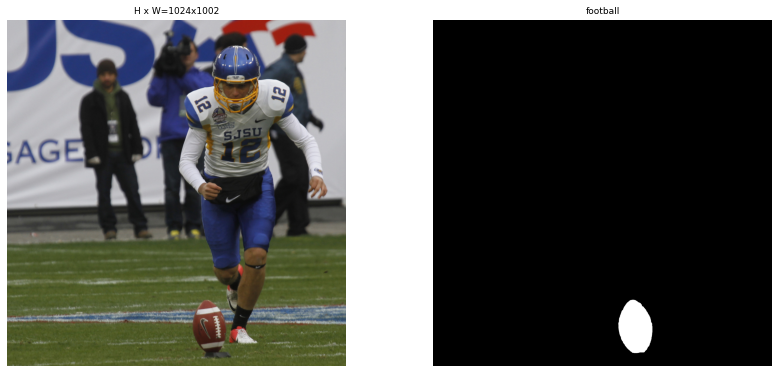

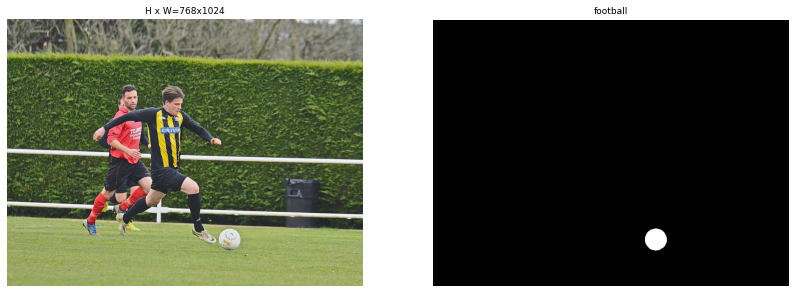

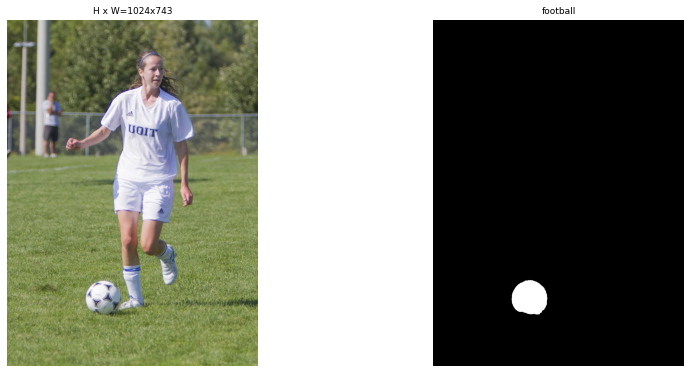

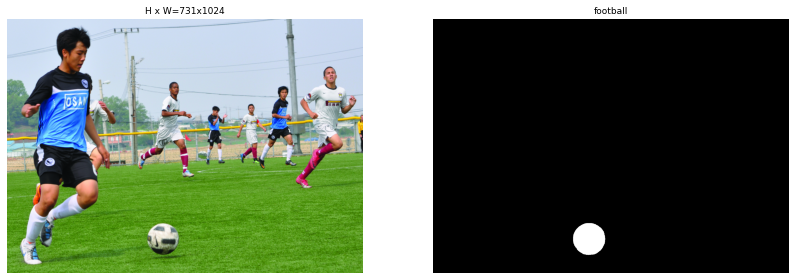

In [ ]:
# Load and display random samples
image_ids = np.random.choice(football_dataset_train.image_ids, 4)
print(image_ids)
for image_id in image_ids:
#    print(image_id)
    image = football_dataset_train.load_image(image_id)
    mask, class_ids = football_dataset_train.load_mask(image_id)
    img = image[:,:,[2,1,0]]
    visualize.display_top_masks(img, mask, class_ids, football_dataset_train.class_names,limit=1)

##Train the network

###Setup Training env and path

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath(PROJECT_WORKING_PATH)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Helper function to Plot

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

###Create Mask-RCNN Model 

In [ ]:
# Create model in training mode

model = modellib.MaskRCNN(mode="training", config=football_config,model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


###Load pre-trained Weights

In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    print("suing coco weights")
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

suing coco weights


###Start Actuall Trainning

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(football_dataset_train, football_dataset_val, 
            learning_rate=football_config.LEARNING_RATE,
            epochs=100, 
            layers="all")


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/ml_data/MLProject2020/MaskRcnn_TF2.0/Mask_RCNN/logs/football20201213T0911/mask_rcnn_football_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (B

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


49/50 [============================>.] - ETA: 2s - loss: 1.1951 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.5856 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.4505 - mrcnn_mask_loss: 0.0871
Epoch 00001: saving model to /content/drive/MyDrive/ml_data/MLProject2020/MaskRcnn_TF2.0/Mask_RCNN/logs/football20201213T0911/mask_rcnn_football_0001.h5
50/50 [==============================] - 264s 5s/step - loss: 1.1877 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.5843 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.4460 - mrcnn_mask_loss: 0.0867 - val_loss: 1.0314 - val_rpn_class_loss: 0.0061 - val_rpn_bbox_loss: 0.7593 - val_mrcnn_class_loss: 0.0195 - val_mrcnn_bbox_loss: 0.1466 - val_mrcnn_mask_loss: 0.0999
Epoch 2/100
49/50 [============================>.] - ETA: 0s - loss: 1.1114 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.8158 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.1086
Epoch 00002: saving model to /content/drive/MyDrive/ml_data/MLProject2020/MaskRcnn_TF2.

When the training is done, colab will beep to notify

In [ ]:
# Sleep for a few seconds.
import time
time.sleep(2)

# Play an audio beep. Any audio URL will do.
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

##Detection

In [ ]:
class InferenceConfig(FootballConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()
# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Loading weights from  /content/drive/MyDrive/ml_data/MLProject2020/MaskRcnn_TF2.0/Mask_RCNN/logs/football20201213T0911/mask_rcnn_football_0100.h5
Re-starting from epoch 100


The ground truth

raw_image                shape: (553, 1024, 3)        min:    0.00000  max:  255.00000  uint8
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  635.00000  max:  741.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:  255.00000  uint8


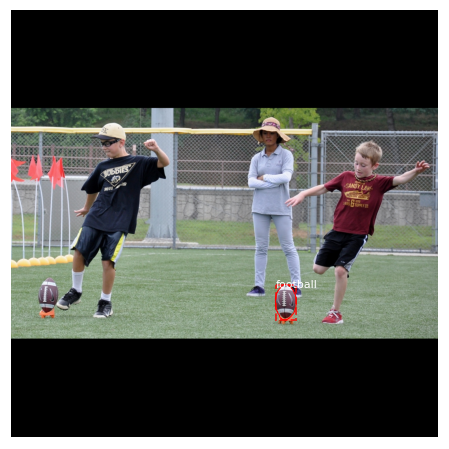

In [ ]:
import mrcnn.model as modellib
from mrcnn import visualize


# Test on a random image
image_id = random.choice(football_dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
modellib.load_image_gt(football_dataset_val, inference_config, 
                        image_id)
raw_image = football_dataset_val.load_image(image_id)
log("raw_image", raw_image)
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                          football_dataset_train.class_names, figsize=(8, 8))


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


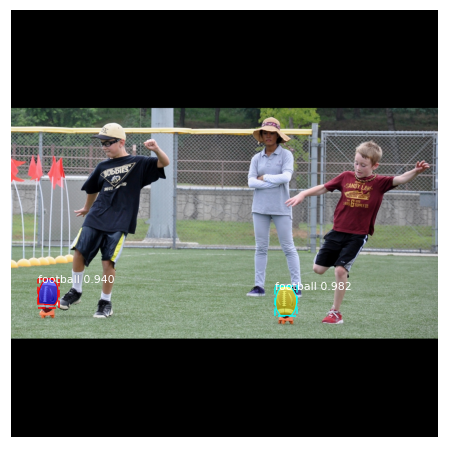

In [ ]:
results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            football_dataset_val.class_names, r['scores'], ax=get_ax())

##Model summary

In [ ]:
#model summary of our model
model.keras_model.summary()

Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________

##Evaluation

In some datasets, we predefine an IoU threshold (say 0.5) in classifying whether the prediction is a true positive or a false positive.
Refer:
https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173

In [ ]:
!ls ./logs/

football20201212T1453  football20201213T0911


In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.

image_ids = np.random.choice(football_dataset_val.image_ids, 100)

X = []
Y = []
for i in range(0,100):
    if(i==0): 
      i=1
    if(i == 100):
      i= 99
    if(i < 10):
      model_name = "./logs/football20201213T0911/mask_rcnn_football_000"+str(i)+".h5"
    else:
      model_name = "./logs/football20201213T0911/mask_rcnn_football_00"+str(i)+".h5"

    if(i!=0):
      print("Loading model:",model_name);
      model.load_weights(model_name, by_name=True)
    APs = []
    for image_id in image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(football_dataset_val, inference_config,
                                  image_id)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                            r["rois"], r["class_ids"], r["scores"], r['masks'],iou_threshold=0.9)
        APs.append(AP)
    X.append(i)
    Y.append(np.mean(APs))     
    print("mAP: ", np.mean(APs))
print("Result",X)
print("Result",Y)
import matplotlib.pyplot as plt
plt.plot(X, Y, 'r')
plt.xlabel('Number of Traing Epoch')
plt.ylabel('Average Precison')
plt.show()

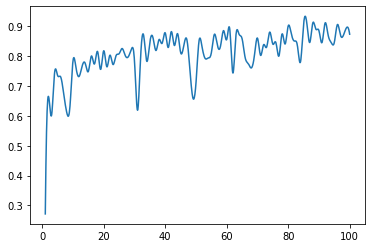

In [ ]:
from scipy import interpolate
x_new = np.linspace(1, 100, 1000)
#print(x_new)
a_BSpline = interpolate.make_interp_spline(np.array(X[1:]), np.array(Y[1:]))
#print(a_BSpline)
y_new = a_BSpline(x_new)
#print(y_new)
plt.plot(x_new, y_new)

In [ ]:
!pip install scipy

#Open image dataset download

In [ ]:
pip install openimages

Download the data into google drive

In [ ]:
!oi_download_images --csv_dir ./scissors --base_dir ./scissors --labels Football

For a specific Imange Id, we can find it in the file "train-annotations-object-segmentation.csv", which states the size and position of the bbox.

In [ ]:
!grep -rsn 00a8d854441ef854 *.csv

Check the Data

In [ ]:
!sed -n 1,10p /content/drive/MyDrive/ml_data/MLProject2020/football/train-annotations-object-segmentation.csv

In [ ]:
#!sed -n 1,10p ./scissors/train-annotations-bbox.csv
!grep -rsn 00a8d854441ef854 ./MLProject2020/train-annotations-bbox.csv

###Helper 

In [ ]:
%cd {DATASET_PATH_PICTURE_TRAIN}
#%cd /content/drive/MyDrive/ml_data/MLProject2020/football/images
!find . -name "5a6e"

In [ ]:
!wget https://storage.googleapis.com/openimages/v5/train-annotations-object-segmentation.csv /content/drive/MyDrive/ml_data/MLProject2020/

In [ ]:
!grep -rs 01226z /content/drive/MyDrive/ml_data/MLProject2020/football/train-annotations-object-segmentation.csv > /content/drive/MyDrive/ml_data/MLProject2020/football/football-train-annotations-object-setgmentation.csv

In [ ]:
!sed -i '1 i\MaskPath,ImageID,LabelName,BoxID,BoxXMin,BoxXMax,BoxYMin,BoxYMax,PredictedIoU,Clicks' /content/drive/MyDrive/ml_data/MLProject2020/football/football-train-annotations-object-setgmentation.csv

In [ ]:
pip install wget

In [ ]:
import wget
# for i in range(1,10):
#   url = 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-' + str(i) + '.zip'
#   local_name = './MLProject2020/train-masks-' + str(i) + '.zip'
#   print("Downloading From:", url)
#   print("Storing To:",local_name)
#   wget.download(url, local_name)
for i in ['a','b','c','d','e','f']:
  url = 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-' + i + '.zip'
  local_name = '/content/drive/MyDrive/ml_data/MLProject2020/train-masks-' + i + '.zip'
  print("Downloading From:", url)
  print("Storing To:",local_name)
  wget.download(url, local_name)

Unzip all the mask pictures

In [ ]:
%cd /content/drive/MyDrive/ml_data/MLProject2020/masks_all

/content/drive/MyDrive/ml_data/MLProject2020/masks_all


In [ ]:
#!cd /content/drive/MyDrive/ml_data/MLProject2020/masks_all
# for i in range(10):
#   file_name = "/content/drive/MyDrive/ml_data/MLProject2020/train-masks-"+str(i)+".zip"
#   !unzip $file_name "*m01226z*.png" 
for i in ['a','b','c','d','e','f'] :
  file_name = "/content/drive/MyDrive/ml_data/MLProject2020/train-masks-"+ i +".zip"
  !unzip $file_name "*m01226z*.png" 

In [ ]:
!echo "Number of image of Current Class "
!ls -l /content/drive/MyDrive/ml_data/MLProject2020/football/images/ | grep "^-" | wc -l
!echo "Number of masked images is "
!ls -l /content/drive/MyDrive/ml_data/MLProject2020/masks_all | grep "^-" | wc -l

Number of image of Current Class 
3127
Number of masked images is 
2893


In [ ]:
a = tf.keras.datasets.mnist.load_data(
    path='mnist.npz'
)

In [ ]:

img=Image.open(/content/drive/MyDrive/ml_data/  )
plt.figure("dog")
plt.imshow(a[0][0][2])
plt.show()

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git

In [ ]:
!pwd

In [ ]:
%cd /content/drive/MyDrive/workspace/

In [ ]:
pip install --upgrade kaggle

In [ ]:
!cp ./kaggle.json /root/.kaggle/

In [ ]:
pip install tensorflow==1.14